# Damper Anomalies Detection Using AML Package for Computer Vision
This approach uses object detection libary from Microsoft https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-build-deploy-object-detection-models
This libary itself is the wrapper from tensorflow object detection API which is implemented in another notebook.
The key to achieve good performance in limited data situation is data augmentation. Below are steps to generate more data.
The weakness of this method is it requires you to use machine learning workbench libraries which comes with lots of limitation on common ML packages that you install, including tensorflow (version 1.4 was used). You cannot customize a lot of training parameters and network architecture such as learning rate schemes
Also it can only be deployed to ACI which is not production grade solution.
But using this libary is a quick way to evaluate custom object solution for your requirement.

In [256]:
import warnings
warnings.filterwarnings("ignore")
import os, time
from cvtk.core import Context, ObjectDetectionDataset, TFFasterRCNN
from cvtk.evaluation import DetectionEvaluation
from cvtk.evaluation.evaluation_utils import graph_error_counts
from cvtk.utils import detection_utils

# Disable printing of logging messages
from azuremltkbase.logging import ToolkitLogger
ToolkitLogger.getInstance().setEnabled(False)

from matplotlib import pyplot as plt
# Display the images
%matplotlib inline

### Data Augmentation

In [ ]:
#Generate additional data from current dataset. Run this against the directory that contain original training data
#This procedure automatically adapt coodinates of bboxes to different images's size. You can add more augmentation 
#technique to generate more data. 
import imgaug as ia
from imgaug import augmenters as iaa
from scipy import misc
import os
import glob
from xml import etree

def transform(image, bboxes):

#     ia.seed(1)

    bbs = ia.BoundingBoxesOnImage([
        ia.BoundingBox(x1=bbox['x1'], y1=bbox['y1'], x2=bbox['x2'], y2=bbox['y2']) 
        for bbox in bboxes
    ], shape=image.shape)

    seq = iaa.Sequential([
        iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
        iaa.Affine(
            translate_px={"x": 40, "y": 60},
            scale=(0.6, 0.9),
            rotate=(-25, 25),
        ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
    ])

    # Make our sequence deterministic.
    # We can now apply it to the image and then to the BBs and it will
    # lead to the same augmentations.
    # IMPORTANT: Call this once PER BATCH, otherwise you will always get the
    # exactly same augmentations for every batch!
    seq_det = seq.to_deterministic()

    # Augment BBs and images.
    # As we only have one image and list of BBs, we use
    # [image] and [bbs] to turn both into lists (batches) for the
    # functions and then [0] to reverse that. In a real experiment, your
    # variables would likely already be lists.
    image_aug = seq_det.augment_images([image])[0]
    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

#     # print coordinates before/after augmentation (see below)
#     # use .x1_int, .y_int, ... to get integer coordinates
#     for i in range(len(bbs.bounding_boxes)):
#         before = bbs.bounding_boxes[i]
#         after = bbs_aug.bounding_boxes[i]
#         print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
#             i,
#             before.x1, before.y1, before.x2, before.y2,
#             after.x1, after.y1, after.x2, after.y2)
#         )

#     # image with BBs before/after augmentation (shown below)
#     image_before = bbs.draw_on_image(image, thickness=2)
#     image_after = bbs_aug.draw_on_image(image_aug, thickness=2, color=[0, 0, 255])
    return image_aug, bbs_aug.bounding_boxes
def transform_and_save(org_dir, count=1):


    for img in glob.glob(org_dir+"/*.jpg"):
       
        image = misc.imread(img)
        bboxes=[]
        e = etree.ElementTree.parse(img[:-3]+"xml")
        root = e.getroot()

        obj_xml = root.findall('object')
        file_name = root.find('filename')
        for obj in obj_xml:
            bbox_original = obj.find('bndbox')
            bboxes.append({"x1":int(bbox_original.find('xmin').text),
                           "y1":int(bbox_original.find('ymin').text),
                           "x2":int(bbox_original.find('xmax').text),
                           "y2":int(bbox_original.find('ymax').text)})
        for i in range(count):    
            new_image, new_bboxes = transform(image, bboxes)
            for new_bbox, obj in zip (new_bboxes,obj_xml):
                name = obj.find('name')
            #     bbox_mod = objects_an[name.text] # do a try catch here
        #         print("name: ", name.text)

                bbox_original = obj.find('bndbox')

                bbox_original.find('xmin').text = str(int(new_bbox.x1))
                bbox_original.find('ymin').text = str(int(new_bbox.y1))
                bbox_original.find('xmax').text = str(int(new_bbox.x2))
                bbox_original.find('ymax').text = str(int(new_bbox.y2))
            e.write(img[:-4]+str(i)+".xml")
            misc.imsave(img[:-4]+str(i)+".jpg", new_image)
org_dir = "C:/Users/james/Downloads/dampers/train_multi_classes - augmented_v2"
#we generate 4 copies of each original photo 
transform_and_save(org_dir,4)

## Create a dataset



In [77]:
#Point to the folder containing the augmented training data
image_folder = "C:/Users/james/Downloads/dampers/train_multi_classes - augmented_v2"

data_train = ObjectDetectionDataset.create_from_dir(dataset_name='training_dataset', data_dir=image_folder,
                                                    annotations_dir="", image_subdirectory='')

# Show some statistics of the training image, and also give one example of the ground truth rectangle annotations
data_train.print_info()
# _ = data_train.images[15].visualize_bounding_boxes(image_size = (10,10))

F1 2018-08-20 05:31:54,970 INFO azureml.vision:dataset creating dataset for scenario=detection 
Dataset name: training_dataset
Total classes: 4, total images: 77
Label-wise object counts:
	Label damaged_conductor: 56 objects
	Label damaged_damper: 62 objects
	Label discolor: 143 objects
	Label missing: 55 objects
Bounding box width and height distribution:
	Bounding box widths  0/5/25/50/75/95/100-percentile: 225/359/494/608/850/1495/1596 pixels
	Bounding box heights 0/5/25/50/75/95/100-percentile: 106/109/169/234/281/495/588 pixels


## Define detection model


In [64]:
score_threshold = 0.0       # Threshold on the detection score, use to discard lower-confidence detections.
min_dimension = 2100
max_dimension = 3000
max_total_detections = 500  # Maximum number of detections. A high value slows down training but might increase accuracy.
my_detector = TFFasterRCNN(labels=data_train.labels,min_dimension=min_dimension, max_dimension= max_dimension,
                           score_threshold=score_threshold, 
                           max_total_detections=max_total_detections)

## Train the model

The COCO-trained Faster R-CNN model with ResNet50 is used as the starting point for training. 



In [160]:
print("tensorboard --logdir={}".format(my_detector.train_dir))

# to get good results, use a larger value for num_steps, e.g., 5000.
num_steps = 30000
learning_rate = 0.001 # learning rate

start_train = time.time()
my_detector.train(dataset=data_train, num_steps=num_steps, 
                  initial_learning_rate=learning_rate)
end_train = time.time()
print(end_train-start_train)

tensorboard --logdir=C:\Users\james\AppData\Local\Temp\2\azureml_runs\cvp_project_1534533156709\temp\temp_faster_rcnn_resnet50\models\train
F1 2018-08-21 00:10:21,086 INFO azureml.vision:Fit starting in experiment 2020330843 
F1 2018-08-21 00:10:21,089 INFO azureml.vision:model starting trainging for scenario=detection 
Using existing checkpoint file that's saved at 'C:\Users\james\.azureml\share\james_tn_ml\JamesWorkspace\cvp_project\models\detection\faster_rcnn_resnet50_coco_2018_01_28\model.ckpt.index'.
TFRecords creation started.
F1 2018-08-21 00:10:21,098 INFO On image 0 of 77
TFRecords creation completed.
Training started.
Training progressing: step 0 ...
Training progressing: step 100 ...
Training progressing: step 200 ...
Training progressing: step 300 ...
Training progressing: step 400 ...
Training progressing: step 500 ...
Training progressing: step 600 ...
Training progressing: step 700 ...
Training progressing: step 800 ...
Training progressing: step 900 ...
Training progre

Training progressing: step 19300 ...
Training progressing: step 19400 ...
Training progressing: step 19500 ...
Training progressing: step 19600 ...
Training progressing: step 19700 ...
Training progressing: step 19800 ...
Training progressing: step 19900 ...
Training progressing: step 20000 ...
Training progressing: step 20100 ...
Training progressing: step 20200 ...
Training progressing: step 20300 ...
Training progressing: step 20400 ...
Training progressing: step 20500 ...
Training progressing: step 20600 ...
Training progressing: step 20700 ...
Training progressing: step 20800 ...
Training progressing: step 20900 ...
Training progressing: step 21000 ...
Training progressing: step 21100 ...
Training progressing: step 21200 ...
Training progressing: step 21300 ...
Training progressing: step 21400 ...
Training progressing: step 21500 ...
Training progressing: step 21600 ...
Training progressing: step 21700 ...
Training progressing: step 21800 ...
Training progressing: step 21900 ...
T

## Evaluate the model

The 'evaluate' method is used to evaluate the model. This function requires an ObjectDetectionDataset object as an input. The evaluation dataset can be created using the same function as the one used for the training dataset. The supported metric is Average Precision as defined for the [PASCAL VOC Challenge](http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf).  

In [161]:
#training performance for model 7
image_folder = "C:/Users/james/Downloads/dampers/train_multi_classes"
data_val = ObjectDetectionDataset.create_from_dir(dataset_name='val_dataset', data_dir=image_folder,annotations_dir="", image_subdirectory='')
eval_result = my_detector.evaluate(dataset=data_val)

F1 2018-08-22 01:27:21,710 INFO azureml.vision:dataset creating dataset for scenario=detection 
F1 2018-08-22 01:27:22,163 INFO On image 0 of 77
F1 2018-08-22 01:27:35,305 INFO Starting evaluation at 2018-08-22-01:27:35
F1 2018-08-22 01:27:38,791 INFO Creating detection visualizations.
F1 2018-08-22 01:27:49,047 INFO Detection visualizations written to summary with tag image-0.
F1 2018-08-22 01:27:50,298 INFO Creating detection visualizations.
F1 2018-08-22 01:27:59,791 INFO Detection visualizations written to summary with tag image-1.
F1 2018-08-22 01:28:00,953 INFO Creating detection visualizations.
F1 2018-08-22 01:28:11,463 INFO Detection visualizations written to summary with tag image-2.
F1 2018-08-22 01:28:12,607 INFO Creating detection visualizations.
F1 2018-08-22 01:28:22,125 INFO Detection visualizations written to summary with tag image-3.
F1 2018-08-22 01:28:23,237 INFO Creating detection visualizations.
F1 2018-08-22 01:28:33,462 INFO Detection visualizations written to s

In [79]:
image_folder = "C:/Users/james/Downloads/dampers/train_multi_classes"
data_val = ObjectDetectionDataset.create_from_dir(dataset_name='val_dataset', data_dir=image_folder,annotations_dir="", image_subdirectory='')
eval_result = my_detector.evaluate(dataset=data_val)

F1 2018-08-20 22:29:43,698 INFO azureml.vision:dataset creating dataset for scenario=detection 
F1 2018-08-20 22:29:44,000 INFO On image 0 of 77
F1 2018-08-20 22:29:56,507 INFO Starting evaluation at 2018-08-20-22:29:56
F1 2018-08-20 22:30:00,075 INFO Creating detection visualizations.
F1 2018-08-20 22:30:10,250 INFO Detection visualizations written to summary with tag image-0.
F1 2018-08-20 22:30:11,463 INFO Creating detection visualizations.
F1 2018-08-20 22:30:21,905 INFO Detection visualizations written to summary with tag image-1.
F1 2018-08-20 22:30:23,048 INFO Creating detection visualizations.
F1 2018-08-20 22:30:33,845 INFO Detection visualizations written to summary with tag image-2.
F1 2018-08-20 22:30:34,984 INFO Creating detection visualizations.
F1 2018-08-20 22:30:44,719 INFO Detection visualizations written to summary with tag image-3.
F1 2018-08-20 22:30:45,845 INFO Creating detection visualizations.
F1 2018-08-20 22:30:55,907 INFO Detection visualizations written to s

In [163]:
#This is version 7
image_folder = "C:/Users/james/Downloads/dampers/val_multi_classes"

data_val = ObjectDetectionDataset.create_from_dir(dataset_name='val_dataset', data_dir=image_folder,annotations_dir="", image_subdirectory='')
eval_result = my_detector.evaluate(dataset=data_val)


# print out the performance metric values
for label_obj in data_train.labels:
    label = label_obj.name
    key = 'PASCAL/PerformanceByCategory/AP@0.5IOU/' + label
    print('{0: <15}: {1: <3}'.format(label, round(eval_result[key], 2)))
print('{0: <15}: {1: <3}'.format("overall:", round(eval_result['PASCAL/Precision/mAP@0.5IOU'], 2))) 

F1 2018-08-22 01:32:51,840 INFO azureml.vision:dataset creating dataset for scenario=detection 
F1 2018-08-22 01:32:51,895 INFO On image 0 of 22
F1 2018-08-22 01:32:58,516 INFO Starting evaluation at 2018-08-22-01:32:58
F1 2018-08-22 01:33:01,751 INFO Creating detection visualizations.
F1 2018-08-22 01:33:10,791 INFO Detection visualizations written to summary with tag image-0.
F1 2018-08-22 01:33:11,995 INFO Creating detection visualizations.
F1 2018-08-22 01:33:20,900 INFO Detection visualizations written to summary with tag image-1.
F1 2018-08-22 01:33:22,028 INFO Creating detection visualizations.
F1 2018-08-22 01:33:31,104 INFO Detection visualizations written to summary with tag image-2.
F1 2018-08-22 01:33:32,214 INFO Creating detection visualizations.
F1 2018-08-22 01:33:40,587 INFO Detection visualizations written to summary with tag image-3.
F1 2018-08-22 01:33:41,728 INFO Creating detection visualizations.
F1 2018-08-22 01:33:50,609 INFO Detection visualizations written to s

In [ ]:
print("tensorboard --logdir={} --port=8008".format(my_detector.eval_dir))

It is often necessary to choose a threshold at which to reject low confidence detections. The figure below helps with selecting this threshold by showing, for different thresholds, the number of images with at least one error in them (solid red line). These errors are analysed further into images with at least one ground truth object not found (dotted green line), and images with at least one wrong detection (dotted blue line). Optionally, if a path to an image folder is specified (typically images which do not contain the object-of-interest, hence the name "negative images"), the number of these images with at least one detection is shown (solid yellow line).

Scoring 5 images...
Scoring 0 negative images...


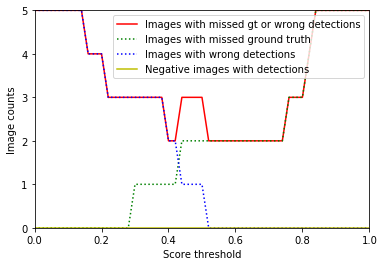

In [7]:
neg_imgs_dir="classification/sample_data/imgs_recycling/cup"
de = DetectionEvaluation(my_detector, data_val, neg_imgs_dir)
ax = graph_error_counts(de)

## Score an image



C:/Users/james/Downloads/dampers/val_multi_classes\DSC_8634.jpg
c:/Users/james/Downloads/scored_images/scored_image_preloaded.jpg


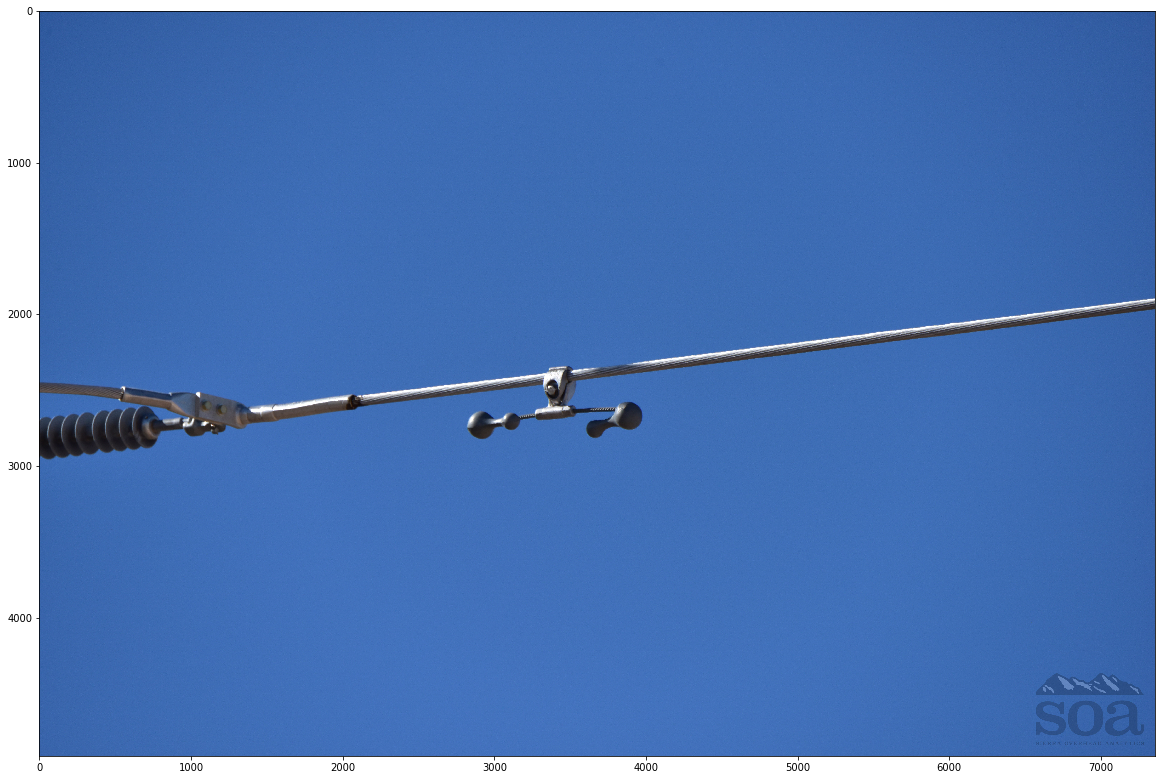

In [425]:
#This is for model version 6
#in case you run this notebook after a restart, reload the model from here:
# save_model_path = "C:/Users/james/Downloads/dampers/models/faster_rcnn_v6.model"

# my_detector_loaded = TFFasterRCNN.load(save_model_path)

image_path = data_val.images[20].storage_path
print(image_path)
detections_dict = my_detector_loaded.score(image_path)
path_save = "c:/Users/james/Downloads/scored_images/scored_image_preloaded.jpg"
ax = detection_utils.visualize(image_path, detections_dict, image_size=(20,20 ),min_score_thresh=0.2)
path_save_dir = os.path.dirname(os.path.abspath(path_save))
print(path_save)
os.makedirs(path_save_dir, exist_ok=True)
ax.get_figure().savefig(path_save)

In [ ]:
#This is for model version 7 which has worse performance. 
image_path = data_val.images[7].storage_path
print(image_path)
detections_dict = my_detector.score(image_path)
path_save = "c:/Users/james/Downloads/scored_images/scored_image_preloaded.jpg"
ax = detection_utils.visualize(image_path, detections_dict, image_size=(40,40 ),min_score_thresh=0.1)
path_save_dir = os.path.dirname(os.path.abspath(path_save))
print(path_save)
os.makedirs(path_save_dir, exist_ok=True)
ax.get_figure().savefig(path_save)

##  Save the model



In [343]:
#Saving version 7
save_model_path = "C:/Users/james/Downloads/dampers/models/faster_rcnn_v7.model"
my_detector.save(save_model_path)

F1 2018-08-23 05:38:51,702 INFO Graph Rewriter optimizations enabled
Converted 275 variables to const ops.
F1 2018-08-23 05:39:02,270 INFO 2541 ops in the final graph.


## Load the saved model for scoring



In [344]:
save_model_path = "C:/Users/james/Downloads/dampers/models/faster_rcnn_v6.model"

my_detector_loaded = TFFasterRCNN.load(save_model_path)

After the model is loaded, it can be used to score an image or a list of images. For a single image, a dictionary is returned with keys such as 'detection_boxes', 'detection_scores', and 'num_detections'. If the input is a list of images, a list of dictionary is returned, with one dictionary corresponding to one image. 

In [15]:
detections_dict = my_detector_loaded.score(image_path)

The detected objects with scores above 0.5, including labels, scores, and coordinates can be printed out.

In [325]:
look_up = dict((v,k) for k,v in my_detector.class_map.items())

n_obj = 0
for i in range(detections_dict['num_detections']):
    if detections_dict['detection_scores'][i] > 0.5:
        n_obj += 1
        print("Object {}: label={:11}, score={:.2f}, location=(top: {:.2f}, left: {:.2f}, bottom: {:.2f}, right: {:.2f})".format(
            i, look_up[detections_dict['detection_classes'][i]], 
            detections_dict['detection_scores'][i], 
            detections_dict['detection_boxes'][i][0],
            detections_dict['detection_boxes'][i][1], 
            detections_dict['detection_boxes'][i][2],
            detections_dict['detection_boxes'][i][3]))    
        
print("\nFound {} objects in image {}.".format(n_obj, image_path))           

Object 0: label=damaged_damper, score=0.99, location=(top: 0.86, left: 0.28, bottom: 0.93, right: 0.44)
Object 1: label=damaged_damper, score=0.98, location=(top: 0.87, left: 0.25, bottom: 0.94, right: 0.41)

Found 2 objects in image C:/Users/james/Downloads/dampers/val_multi_classes\171026-0012380579.jpg.


Visualize the scores just like before.

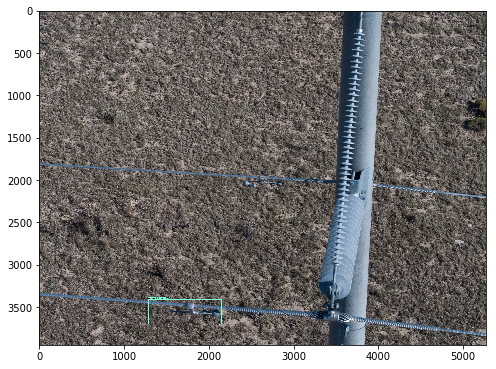

In [388]:
path_save = "./scored_images/scored_image_frozen_graph.jpg"
ax = detection_utils.visualize(image_path, detections_dict, path_save=path_save, image_size=(8, 12))
# ax.get_figure() # use this code extract the returned image

## Operationalization: deploy and consume



In [ ]:
from cvtk.operationalization import AMLDeployment

# set deployment name
deployment_name = "dadwsdeploymentv6"

# Create deployment object
# It will use the current deployment environment (you can check it with CLI command "az ml env show").
deploy_obj = AMLDeployment(deployment_name=deployment_name, aml_env="cluster", associated_DNNModel=my_detector_loaded, replicas=1)

# Alternatively, you can provide azure machine learning deployment cluster name (environment name) and resource group name
# to deploy your model. It will use the provided cluster to deploy. To do that, please uncomment the following lines to create 
# the deployment object.

# azureml_rscgroup = "<resource group>"
# cluster_name = "<cluster name>"
# deploy_obj = AMLDeployment(deployment_name=deployment_name, associated_DNNModel=my_detector,
#                            aml_env="cluster", cluster_name=cluster_name, resource_group=azureml_rscgroup, replicas=1)

# Check if the deployment name exists, if yes remove it first.
if deploy_obj.is_existing_service():
    AMLDeployment.delete_if_service_exist(deployment_name)
    
# create the webservice
print("Deploying to Azure cluster...")
deploy_obj.deploy()
print("Deployment DONE")

### Consume the web service


   - You can directly score the webservice with the deployment object with: deploy_obj.score_image(image_path_or_url) 
   - Or, you can use the Service endpoint url and Service key (None for local deployment) with: AMLDeployment.score_existing_service_with_image(image_path_or_url, service_endpoint_url, service_key=None)
   - Form your http requests directly to score the webservice endpoint (For advanced users).

### Score with service endpoint url and service key
```
    AMLDeployment.score_existing_service_with_image(image_path_or_url, service_endpoint_url, service_key=None)
```

### Score endpoint with http request directly
Following is some example code to form the http request directly in Python. You can do it in other programming languages.See the implementation with the python Django web appp

In [ ]:
def score_image_with_http(image, service_endpoint_url, service_key=None, parameters={}):
    """Score local image with http request

    Args:
        image (str): Image file path
        service_endpoint_url(str): web service endpoint url
        service_key(str): Service key. None for local deployment.
        parameters (dict): Additional request paramters in dictionary. Default is {}.


    Returns:
        str: serialized result 
    """
    import requests
    from io import BytesIO
    import base64
    import json

    if service_key is None:
        headers = {'Content-Type': 'application/json'}
    else:
        headers = {'Content-Type': 'application/json',
                   "Authorization": ('Bearer ' + service_key)}
    payload = []
    encoded = None
    
    # Read image
    with open(image,'rb') as f:
        image_buffer = BytesIO(f.read()) ## Getting an image file represented as a BytesIO object
        
    # Convert your image to base64 string
    # image_in_base64 : "b'{base64}'"
    encoded = base64.b64encode(image_buffer.getvalue())
    image_request = {"image_in_base64": "{0}".format(encoded), "parameters": parameters}
    payload.append(image_request)
    body = json.dumps(payload)
    r = requests.post(service_endpoint_url, data=body, headers=headers)
    try:
        result = json.loads(r.text)
        json.loads(result[0])
    except:
        raise ValueError("Incorrect output format. Result cant not be parsed: " + r.text)
    return result[0]


© 2018 Microsoft. All rights reserved. 